Análise Comparativa de Modelos de Previsão - Com e Sem Lag-Features

O notebook apresenta uma análise comparativa sistemática dos modelos de machine learning para previsão de dados meteorológicos.

Estrutura:

1. Preparação do Ambiente e Dados
2. Criação dos Datasets
3. Avaliação dos Modelos
4. Comparação Final e Conclusões

# Preparação do Ambiente e Dados

## Importação das Bibliotecas


In [23]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


## Carregamento dos Dados


In [24]:


# Definição das colunas do dataset
colunas = [
    'data', 'precipitacao_total', 'pressao_atm_media', 
    'temp_orvalho_media', 'temp_maxima', 'temp_media', 
    'temp_minima', 'umidade_relativa_media', 
    'umidade_relativa_minima', 'umidade_relativa_maxima', 
    'vento_vel_media'
]

# Carregamento dos dados
caminho_csv = '/home/iioulos/Documents/IC_Danilo-Cotozika/Dados do INEP que eu solicitei/dados_A707_D_2014-01-01_2025-05-01.csv'
df = pd.read_csv(
    caminho_csv,
    sep=',', 
    encoding='latin1',
    skiprows=11,
    header=None,
    names=colunas
)

# Verificação de valores faltantes
print("Valores faltantes por coluna:")
df.isna().sum()


Valores faltantes por coluna:


data                         0
precipitacao_total         451
pressao_atm_media          138
temp_orvalho_media         444
temp_maxima                127
temp_media                 174
temp_minima                124
umidade_relativa_media     184
umidade_relativa_minima     30
umidade_relativa_maxima     70
vento_vel_media            140
dtype: int64

## Tratamento de Dados


In [25]:


# Convertendo a coluna de data para datetime
df['data'] = pd.to_datetime(df['data'])

# Interpolação linear para valores faltantes
colunas_numericas = df.select_dtypes(include=[np.number]).columns
df[colunas_numericas] = df[colunas_numericas].interpolate(method='linear')

print("\nValores faltantes após interpolação:")
df.isna().sum()


Valores faltantes após interpolação:


data                       0
precipitacao_total         0
pressao_atm_media          0
temp_orvalho_media         0
temp_maxima                0
temp_media                 0
temp_minima                0
umidade_relativa_media     0
umidade_relativa_minima    0
umidade_relativa_maxima    0
vento_vel_media            0
dtype: int64

# Criação dos Datasets

## Dataset sem Lag-Features


In [26]:


def preparar_dataset_sem_lag(df):
    """
    Prepara o dataset sem utilizar lag-features.
    """
    X = df[[
        'pressao_atm_media', 'temp_orvalho_media', 
        'umidade_relativa_media', 'umidade_relativa_minima',
        'umidade_relativa_maxima', 'vento_vel_media'
    ]]
    y = df['temp_maxima']

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Preparando dados sem lag
X_train_sem_lag, X_test_sem_lag, y_train_sem_lag, y_test_sem_lag = preparar_dataset_sem_lag(df)


## Dataset com Lag-Features


In [27]:


def criar_lag_features(df, lag_dias=[1, 2, 3, 7]):
    """
    Cria lag features para as variáveis selecionadas.
    """
    df_com_lag = df.copy()

    features_para_lag = [
        'temp_maxima', 'pressao_atm_media', 'temp_orvalho_media',
        'umidade_relativa_media', 'vento_vel_media'
    ]

    for feature in features_para_lag:
        for lag in lag_dias:
            df_com_lag[f'{feature}_lag_{lag}'] = df_com_lag[feature].shift(lag)

    return df_com_lag.dropna()

def preparar_dataset_com_lag(df):
    """
    Prepara o dataset utilizando lag-features.
    """
    df_lag = criar_lag_features(df)

    features = [col for col in df_lag.columns if 'lag' in col or col in [
        'pressao_atm_media', 'temp_orvalho_media', 
        'umidade_relativa_media', 'umidade_relativa_minima',
        'umidade_relativa_maxima', 'vento_vel_media'
    ]]

    X = df_lag[features]
    y = df_lag['temp_maxima']

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Preparando dados com lag
X_train_com_lag, X_test_com_lag, y_train_com_lag, y_test_com_lag = preparar_dataset_com_lag(df)

# Avaliação dos Modelos

## Função de Avaliação


Definindo Importância das Features


In [28]:
def avaliar_modelo(modelo, X_train, X_test, y_train, y_test, nome_modelo):
    """
    Treina e avalia um modelo, retornando suas métricas.
    """
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        'modelo': nome_modelo,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [29]:
# Definindo modelos sem lag
modelos_sem_lag = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}
# Treinando e avaliando modelos sem lag
resultados_sem_lag = []
for nome, modelo in modelos_sem_lag.items():
    resultado = avaliar_modelo(
        modelo, X_train_sem_lag, X_test_sem_lag,
        y_train_sem_lag, y_test_sem_lag,
        f"{nome} (Sem Lag)"
    )
    resultados_sem_lag.append(resultado)
    print(f"\nResultados para {nome} (Sem Lag):")
    print(f"RMSE: {resultado['rmse']:.4f}")
    print(f"MAE: {resultado['mae']:.4f}")


Resultados para Random Forest (Sem Lag):
RMSE: 1.1567
MAE: 0.8492

Resultados para Gradient Boosting (Sem Lag):
RMSE: 1.2518
MAE: 0.9228

Resultados para SVR (Sem Lag):
RMSE: 3.5487
MAE: 2.7225


## Treinamento e Avaliação - Sem Lag-Features


In [30]:
# Definindo modelos sem lag
modelos_sem_lag = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Treinando e avaliando modelos sem lag
resultados_sem_lag = []
for nome, modelo in modelos_sem_lag.items():
    resultado = avaliar_modelo(
        modelo, X_train_sem_lag, X_test_sem_lag, 
        y_train_sem_lag, y_test_sem_lag, 
        f"{nome} (Sem Lag)"
    )
    resultados_sem_lag.append(resultado)
    print(f"\nResultados para {nome} (Sem Lag):")
    print(f"RMSE: {resultado['rmse']:.4f}")
    print(f"MAE: {resultado['mae']:.4f}")
    print(f"R²: {resultado['r2']:.4f}")


Resultados para Random Forest (Sem Lag):
RMSE: 1.1567
MAE: 0.8492
R²: 0.9121

Resultados para Gradient Boosting (Sem Lag):
RMSE: 1.2518
MAE: 0.9228
R²: 0.8970

Resultados para SVR (Sem Lag):
RMSE: 3.5487
MAE: 2.7225
R²: 0.1724


## Treinamento e Avaliação - Com Lag-Features


In [31]:
# Definindo modelos com lag
modelos_com_lag = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Treinando e avaliando modelos com lag
resultados_com_lag = []
for nome, modelo in modelos_com_lag.items():
    resultado = avaliar_modelo(
        modelo, X_train_com_lag, X_test_com_lag, 
        y_train_com_lag, y_test_com_lag, 
        f"{nome} (Com Lag)"
    )
    resultados_com_lag.append(resultado)
    print(f"\nResultados para {nome} (Com Lag):")
    print(f"RMSE: {resultado['rmse']:.4f}")
    print(f"MAE: {resultado['mae']:.4f}")
    print(f"R²: {resultado['r2']:.4f}")


Resultados para Random Forest (Com Lag):
RMSE: 1.2936
MAE: 0.9328
R²: 0.8786

Resultados para Gradient Boosting (Com Lag):
RMSE: 1.2680
MAE: 0.9474
R²: 0.8834

Resultados para SVR (Com Lag):
RMSE: 3.5256
MAE: 2.7268
R²: 0.0983


## Análise de Importância das Features pro Random Forest


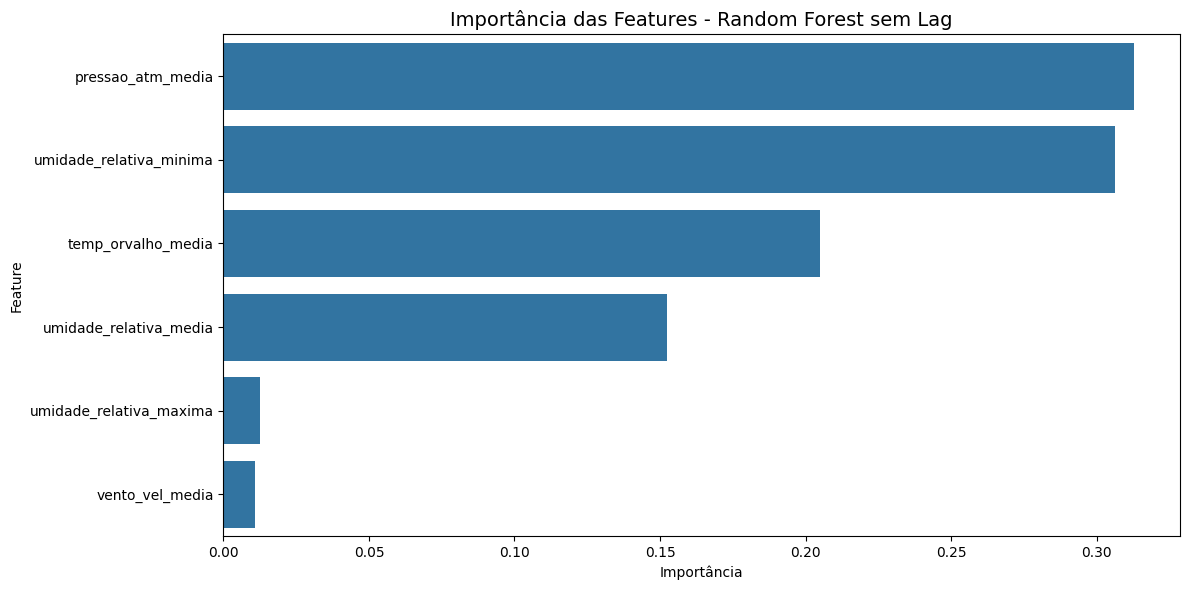


Importância das Features - Random Forest sem Lag:
                   Feature  Importância
0        pressao_atm_media       0.3130
3  umidade_relativa_minima       0.3063
1       temp_orvalho_media       0.2050
2   umidade_relativa_media       0.1522
4  umidade_relativa_maxima       0.0125
5          vento_vel_media       0.0110


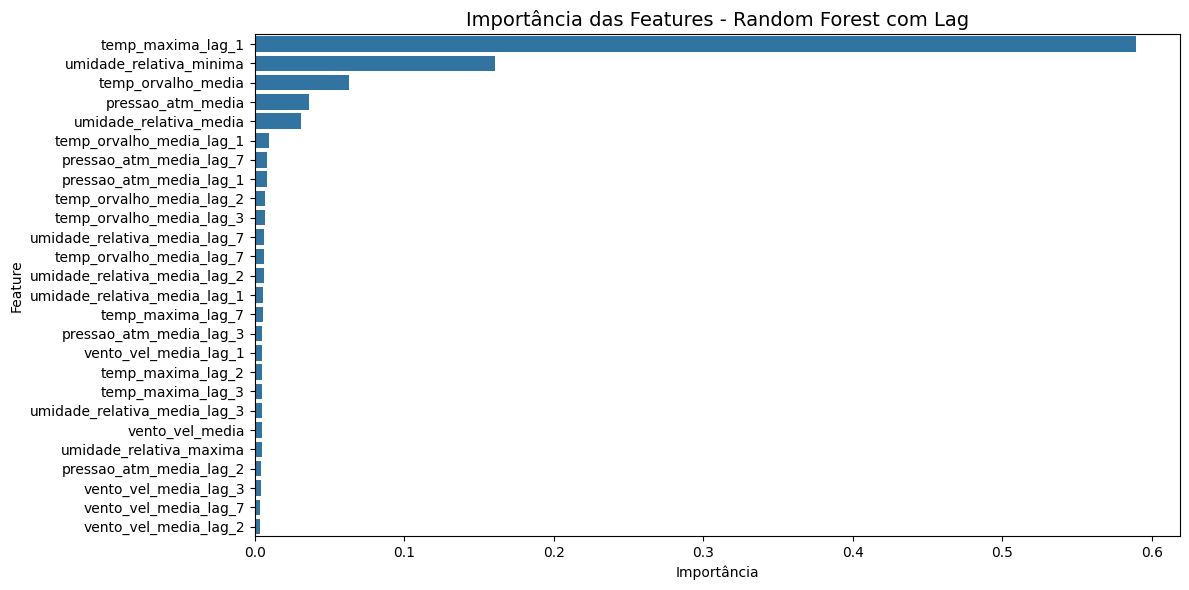


Importância das Features - Random Forest com Lag:
                         Feature  Importância
6              temp_maxima_lag_1       0.5894
3        umidade_relativa_minima       0.1610
1             temp_orvalho_media       0.0633
0              pressao_atm_media       0.0362
2         umidade_relativa_media       0.0311
14      temp_orvalho_media_lag_1       0.0093
13       pressao_atm_media_lag_7       0.0084
10       pressao_atm_media_lag_1       0.0082
15      temp_orvalho_media_lag_2       0.0067
16      temp_orvalho_media_lag_3       0.0066
21  umidade_relativa_media_lag_7       0.0065
17      temp_orvalho_media_lag_7       0.0061
19  umidade_relativa_media_lag_2       0.0060
18  umidade_relativa_media_lag_1       0.0059
9              temp_maxima_lag_7       0.0056
12       pressao_atm_media_lag_3       0.0051
22         vento_vel_media_lag_1       0.0050
7              temp_maxima_lag_2       0.0049
8              temp_maxima_lag_3       0.0048
20  umidade_relativa_media_la

In [32]:
# Random Forest sem Lag
rf_sem_lag = modelos_sem_lag['Random Forest']
importancias_sem_lag = pd.DataFrame({
    'Feature': X_train_sem_lag.columns,
    'Importância': rf_sem_lag.feature_importances_
}).sort_values('Importância', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importância', y='Feature', data=importancias_sem_lag)
plt.title('Importância das Features - Random Forest sem Lag', fontsize=14)
plt.tight_layout()
plt.show()
print("\nImportância das Features - Random Forest sem Lag:")
print(importancias_sem_lag.round(4))

# Random Forest com Lag
rf_com_lag = modelos_com_lag['Random Forest']
importancias_com_lag = pd.DataFrame({
    'Feature': X_train_com_lag.columns,
    'Importância': rf_com_lag.feature_importances_
}).sort_values('Importância', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importância', y='Feature', data=importancias_com_lag)
plt.title('Importância das Features - Random Forest com Lag', fontsize=14)
plt.tight_layout()
plt.show()
print("\nImportância das Features - Random Forest com Lag:")
print(importancias_com_lag.round(4))

# Plot da Comparação entre os Modelos


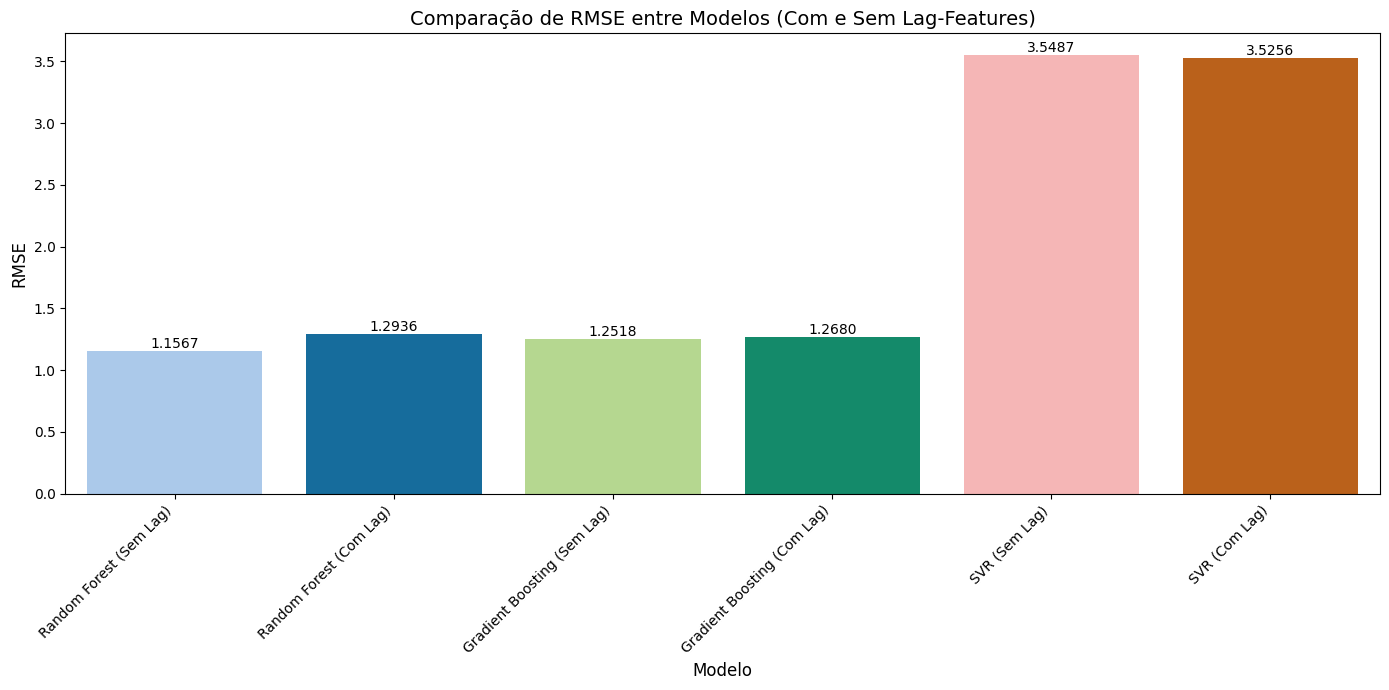

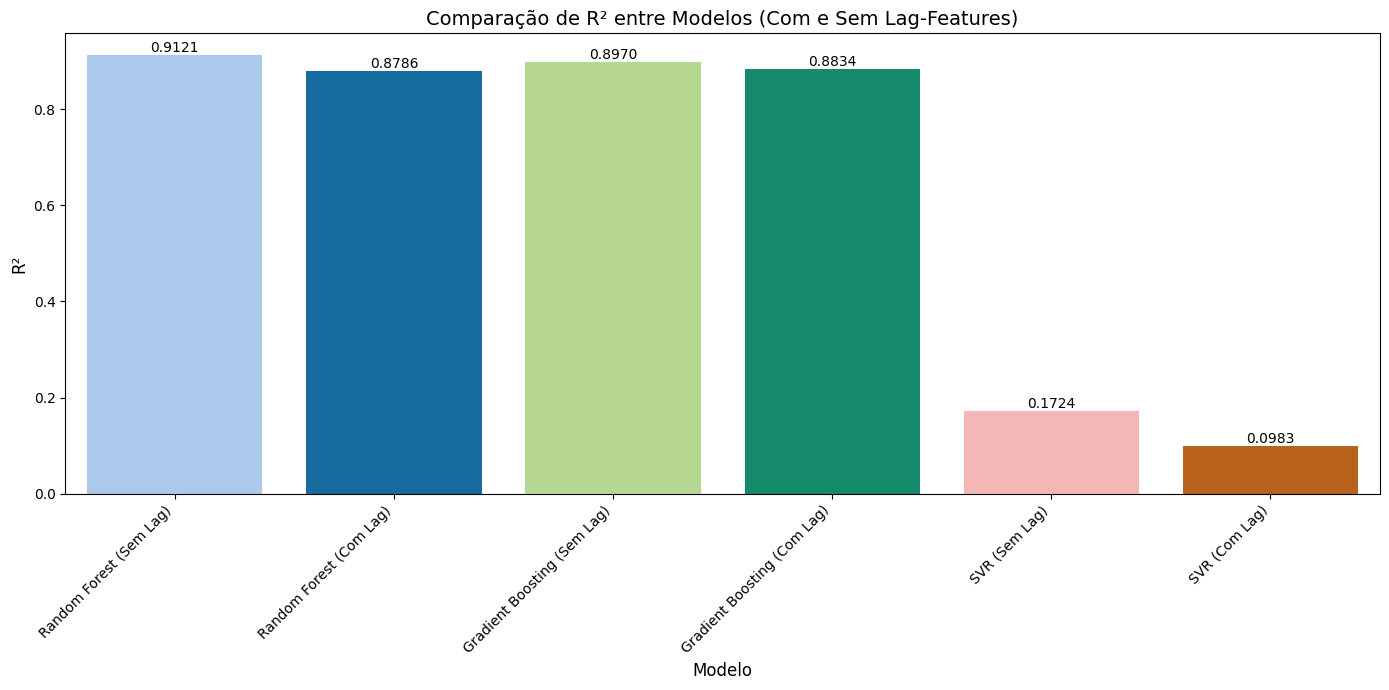


Resultados Detalhados:
                        modelo    rmse     mae      r2
0      Random Forest (Sem Lag)  1.1567  0.8492  0.9121
3      Random Forest (Com Lag)  1.2936  0.9328  0.8786
1  Gradient Boosting (Sem Lag)  1.2518  0.9228  0.8970
4  Gradient Boosting (Com Lag)  1.2680  0.9474  0.8834
2                SVR (Sem Lag)  3.5487  2.7225  0.1724
5                SVR (Com Lag)  3.5256  2.7268  0.0983


In [33]:


# Combinando resultados
todos_resultados = pd.DataFrame(resultados_sem_lag + resultados_com_lag)

# Definindo a ordem personalizada dos modelos
ordem_modelos = [
    'Random Forest (Sem Lag)', 'Random Forest (Com Lag)',
    'Gradient Boosting (Sem Lag)', 'Gradient Boosting (Com Lag)',
    'SVR (Sem Lag)', 'SVR (Com Lag)'
]

# Definindo as cores para cada modelo
cores_modelos = {
    'Random Forest (Sem Lag)': '#A1C9F4',  # Azul pastel
    'Random Forest (Com Lag)': '#0072B2',  # Azul mais escuro
    'Gradient Boosting (Sem Lag)': '#B5E384',  # Verde pastel
    'Gradient Boosting (Com Lag)': '#009E73',  # Verde mais escuro
    'SVR (Sem Lag)': '#FFACAC',  # Vermelho pastel
    'SVR (Com Lag)': '#D55E00'   # Vermelho mais escuro
}

# Ordenando o DataFrame
todos_resultados['modelo'] = pd.Categorical(todos_resultados['modelo'], categories=ordem_modelos, ordered=True)
todos_resultados = todos_resultados.sort_values('modelo')

# Criando visualização comparativa do RMSE
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='modelo', y='rmse', data=todos_resultados, hue='modelo', palette=cores_modelos, legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Comparação de RMSE entre Modelos (Com e Sem Lag-Features)', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tight_layout()

# Adicionando valores nas barras
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

# Criando visualização comparativa do R²
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='modelo', y='r2', data=todos_resultados, hue='modelo', palette=cores_modelos, legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Comparação de R² entre Modelos (Com e Sem Lag-Features)', fontsize=14)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.tight_layout()

# Adicionando valores nas barras
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

# Exibindo tabela de resultados
print("\nResultados Detalhados:")
print(todos_resultados.round(4)) 

# Usando as bibliotecas Lime e SHAP pra interpretar melhor e me certificar dos resultados

## Análise SHAP

Análise de Interpretabilidade dos Modelos 


Calculando valores SHAP...


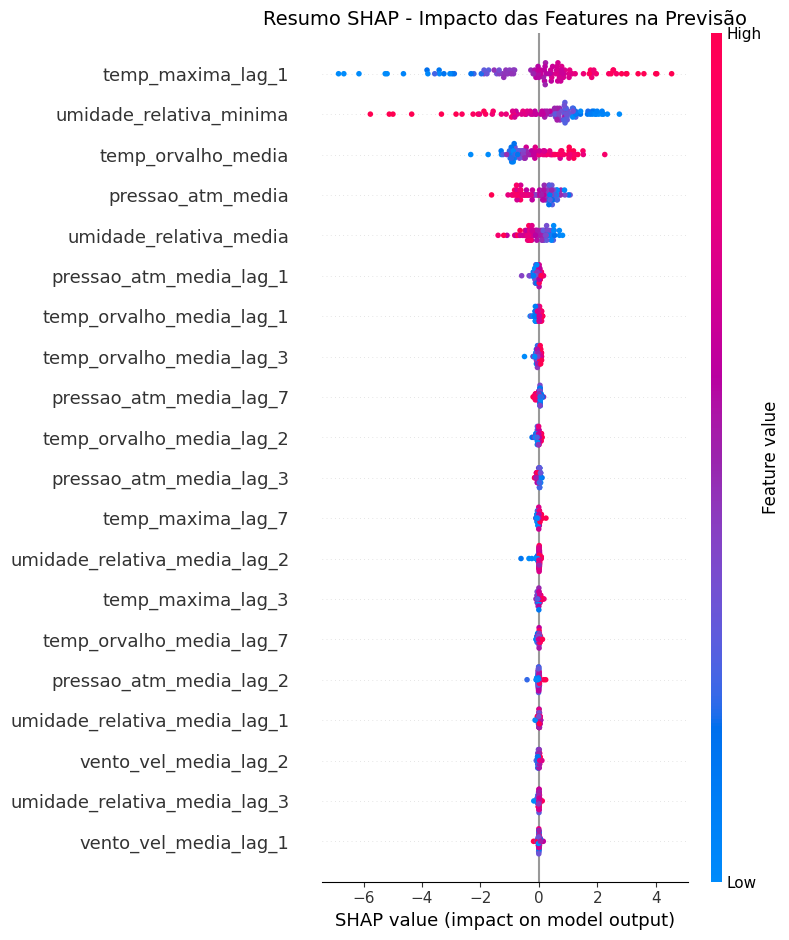

In [34]:
import lime
import lime.lime_tabular
import shap
import time
print("Análise de Interpretabilidade dos Modelos ")
# Selecionando o melhor modelo (Random Forest com Lag)
melhor_modelo = modelos_com_lag['Random Forest']
X_train = X_train_com_lag
X_test = X_test_com_lag
feature_names = X_train.columns.tolist()

print("\n\nCalculando valores SHAP...")
# Usando uma amostra para acelerar o cálculo dos valores SHAP
amostra_idx = np.random.choice(X_train.shape[0], min(100, X_train.shape[0]), 
                              replace=False)
X_train_amostra = X_train.iloc[amostra_idx]
# Criando o explicador SHAP
explainer = shap.TreeExplainer(melhor_modelo)
shap_values = explainer.shap_values(X_train_amostra)
# Resumo das contribuições das features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_amostra, feature_names=feature_names, 
                 show=False)
plt.title('Resumo SHAP - Impacto das Features na Previsão', fontsize=14)
plt.tight_layout()
plt.show()

## Análise LIME

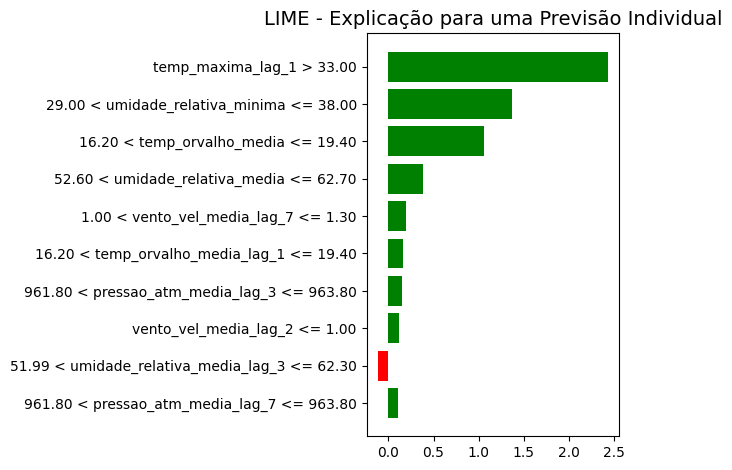

In [35]:

# Criando o explicador LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=['temp_maxima'],
    mode='regression'
)
# Selecionando uma instância aleatória para explicar
idx = np.random.randint(0, len(X_test))
instancia = X_test.iloc[idx]
# Convertendo para DataFrame com os nomes das features para evitar o warning
instancia_df = pd.DataFrame([instancia.values], columns=feature_names)
# Visualizando a explicação LIME
explicacao = explainer_lime.explain_instance(
    instancia.values,
    lambda x: melhor_modelo.predict(pd.DataFrame(x, columns=feature_names)),
    num_features=10
)

# Usando diretamente o método as_pyplot_figure que já cria sua própria figura
fig = explicacao.as_pyplot_figure()
plt.title('LIME - Explicação para uma Previsão Individual', fontsize=14)
plt.tight_layout()
plt.show()

### Comparando previsão vs. valor real


Exemplo de Previsão Individual:
Valor Real: 33.20
Previsão: 33.65
Diferença: 0.45

Comparação entre Métodos de Interpretabilidade


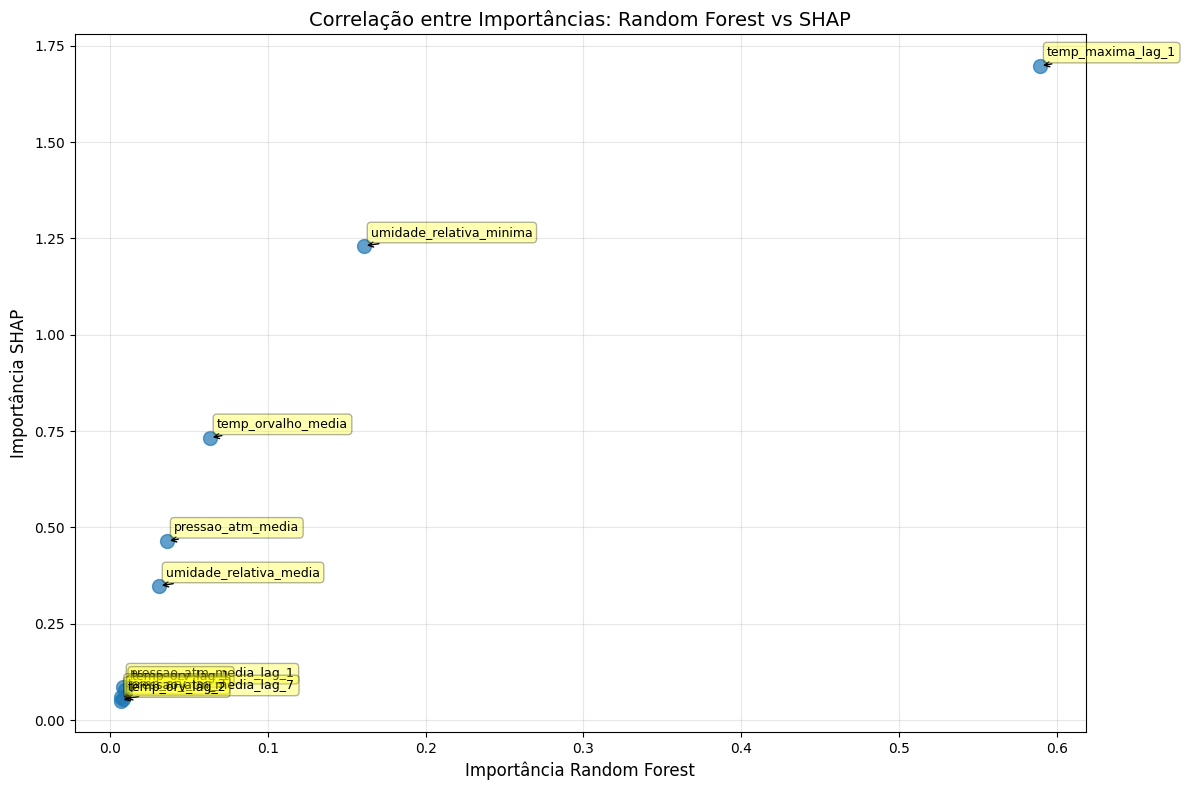


Conclusão da Análise de Interpretabilidade:
1. As features mais importantes segundo o Random Forest são: temp_maxima_lag_1, umidade_relativa_minima, temp_orvalho_media
2. As features mais importantes segundo o SHAP são: temp_maxima_lag_1, umidade_relativa_minima, temp_orvalho_media
3. Consistência entre métodos: 5 de 5 features aparecem em ambos os top 5.


In [36]:
valor_real = y_test_com_lag.iloc[idx]
previsao = melhor_modelo.predict(instancia_df)[0] # Usando DataFrame com nomes de colunas
print(f"\nExemplo de Previsão Individual:")
print(f"Valor Real: {valor_real:.2f}")
print(f"Previsão: {previsao:.2f}")
print(f"Diferença: {abs(valor_real - previsao):.2f}")
# 3. Comparação entre as Importâncias das Features (corrigindo numeração)
print("\nComparação entre Métodos de Interpretabilidade")
# Calculando importância média do SHAP
importancia_shap = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importância': np.abs(shap_values).mean(0)
}).sort_values('SHAP_Importância', ascending=False)

# Obtendo importâncias do modelo Random Forest
if hasattr(melhor_modelo, 'feature_importances_'):
    importancias = pd.DataFrame({
        'Feature': feature_names,
        'Importância': melhor_modelo.feature_importances_
    }).sort_values('Importância', ascending=False)
else:
    # Caso o melhor modelo não seja Random Forest
    importancias = pd.DataFrame({
        'Feature': feature_names,
        'Importância': np.zeros(len(feature_names))  # Valores padrão
    })
    print("Aviso: O modelo não possui atributo feature_importances_")

# Mesclando as importâncias do Random Forest e SHAP
comparacao_importancias = importancia_shap.merge(
    importancias,
    on='Feature',
    how='inner'
).sort_values('SHAP_Importância', ascending=False).head(10)

# Visualizando a comparação com melhor legibilidade
plt.figure(figsize=(12, 8))
plt.scatter(comparacao_importancias['Importância'], 
            comparacao_importancias['SHAP_Importância'],
            alpha=0.7, s=100)

# Melhorando a visualização das anotações para evitar sobreposição
# Criando um dicionário para armazenar as posições dos textos
texto_posicoes = {}
ajuste = 0.001  # Valor inicial de ajuste

# Para cada ponto, verificar se há sobreposição e ajustar posição
for i, txt in enumerate(comparacao_importancias['Feature']):
    x = comparacao_importancias['Importância'].iloc[i]
    y = comparacao_importancias['SHAP_Importância'].iloc[i]
    
    # Abreviando os nomes dos lags de temp_orvalho_media para melhor visualização
    if 'temp_orvalho_media_lag' in txt:
        txt = txt.replace('temp_orvalho_media_lag', 'temp_orv_lag')
    
    # Verificar se há pontos próximos e ajustar posição
    chave = f"{x:.4f}_{y:.4f}"
    if chave in texto_posicoes:
        y += ajuste
        ajuste += 0.001  # Incrementar para o próximo ponto próximo
    texto_posicoes[chave] = True
    
    # Adicionar anotação com offset e conectores
    plt.annotate(txt, 
                 xy=(x, y),
                 xytext=(5, 5),
                 textcoords='offset points',
                 ha='left',
                 va='bottom',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Importância Random Forest', fontsize=12)
plt.ylabel('Importância SHAP', fontsize=12)
plt.title('Correlação entre Importâncias: Random Forest vs SHAP', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\nConclusão da Análise de Interpretabilidade:")
print("1. As features mais importantes segundo o Random Forest são:", ", ".join(importancias.head(3)['Feature'].tolist()))
print("2. As features mais importantes segundo o SHAP são:", ", ".join(importancia_shap.head(3)['Feature'].tolist()))
# Verificando consistência entre os métodos
top5_rf = set(importancias.head(5)['Feature'].tolist())
top5_shap = set(importancia_shap.head(5)['Feature'].tolist())
intersecao = top5_rf.intersection(top5_shap)
print(f"3. Consistência entre métodos: {len(intersecao)} de 5 features aparecem em ambos os top 5.")